This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# xarray powered Cf/Radial and ODIM_H5

In this example, we read and write Cf/Radial (NetCDF) and ODIM_H5 (HDF5) data files from different sources using an xarray powered data structure.

<div class="alert alert-warning">

**Note** <br>

The following functionality is deprecated. Please use the [xarray backend loaders](wradlib_xarray_backends.ipynb) instead.
    
</div>

In [1]:
import wradlib as wrl
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr

try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io.xarray_depr import CfRadial, OdimH5
import tempfile

/home/runner/micromamba-root/envs/wradlib-tests/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load ODIM_H5 Volume Data

In [2]:
fpath = "hdf5/knmi_polar_volume.h5"
f = wrl.util.get_wradlib_data_file(fpath)
cf1 = OdimH5(f, standard="cf", georef=True)

### Inspect root group

You can use the object dictionary using cf1['root'] or the `property` cf1.root.

The `sweep` dimension contains the number of scans in this radar volume. Further the dataset consists of variables (location coordinates, time_coverage) and attributes (Conventions, metadata).

In [3]:
cf1.root

<xarray.Dataset>
Dimensions:              (sweep: 14)
Dimensions without coordinates: sweep
Data variables: (12/14)
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2011-06-10T11:40:02Z'
    time_coverage_end    <U20 '2011-06-10T11:43:54Z'
    ...                   ...
    altitude             float32 50.0
    altitude_agl         float64 nan
    sweep_group_name     (sweep) <U8 'sweep_1' 'sweep_2' ... 'sweep_14'
    sweep_fixed_angle    (sweep) float32 0.3 0.4 0.8 1.1 ... 12.0 15.0 20.0 25.0
    frequency            float64 nan
    status_xml           <U4 'None'
Attributes: (12/19)
    Conventions:          Cf/Radial
    version:              H5rad 2.0
    title:                None
    institution:          RAD:NL51;PLC:nldhl
    references:           None
    source:               None
    ...                   ...
    ray_times_increase:   "true" or "false", assumed "true" if missing. This ...
    field_names:          array of strings of field names present in this file.
    time_coverage_start:  copy of time_coverage_start global variable
    time_coverage_end:    copy of time_coverage_end global variable
    simulated data:       "true" or "false", assumed "false" if missing. data...
    instrument:           RAD:NL51;PLC:nldhl

### Inspect sweep group(s)

The sweep-groups can be accessed via their respective keys. The dimensions consist of `range` and `time` with added coordinates `azimuth`, `elevation`, `range` and `time`. There will be variables like radar moments (DBZH etc.) and sweep-dependend metadata (like `fixed_angle`, `sweep_mode` etc.).

In [4]:
cf1["sweep_1"]

<xarray.Dataset>
Dimensions:       (time: 360, range: 320)
Coordinates: (12/14)
    sweep_mode    <U20 ...
    latitude      float32 ...
    altitude      float32 ...
    longitude     float32 ...
    elevation     (time) float32 ...
    azimuth       (time) float32 ...
    ...            ...
    z             (time, range) float32 ...
    gr            (time, range) float32 ...
    rays          (time, range) float32 ...
    bins          (time, range) float32 ...
    x             (time, range) float32 ...
  * time          (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 201...
Data variables:
    DBZH          (time, range) float32 ...
    sweep_number  int64 ...
    follow_mode   <U4 ...
    prt_mode      <U5 ...
    fixed_angle   float32 ...

In [5]:
cf1["sweep_1"].DBZH

<xarray.DataArray 'DBZH' (time: 360, range: 320)>
[115200 values with dtype=float32]
Coordinates: (12/14)
    sweep_mode  <U20 ...
    latitude    float32 ...
    altitude    float32 ...
    longitude   float32 ...
    elevation   (time) float32 ...
    azimuth     (time) float32 ...
    ...          ...
    z           (time, range) float32 ...
    gr          (time, range) float32 ...
    rays        (time, range) float32 ...
    bins        (time, range) float32 ...
    x           (time, range) float32 ...
  * time        (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 2011-...
Attributes:
    IMAGE_VERSION:  1.2
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    units:          dBZ

### Plotting

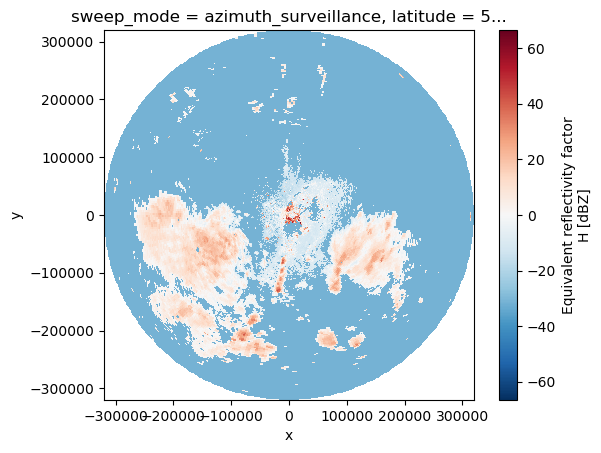

In [6]:
cf1["sweep_1"].DBZH.plot.pcolormesh(x="x", y="y")
pl.gca().set_aspect("equal")

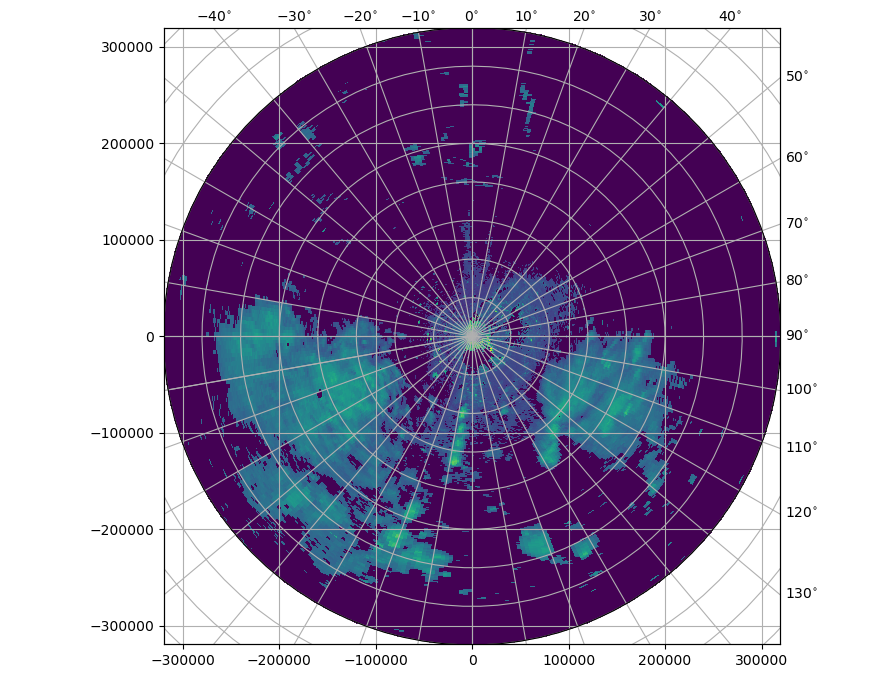

In [7]:
fig = pl.figure(figsize=(10, 8))
cf1["sweep_1"].DBZH.sortby("azimuth").wradlib.plot_ppi(proj="cg", fig=fig)

In [8]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(
    central_latitude=cf1["sweep_1"].latitude.values,
    central_longitude=cf1["sweep_1"].longitude.values,
)

< GeoAxes: +proj=aeqd +ellps=WGS84 +lon_0=4.7899699211120605 +lat_0=52.953338623046875 +x_0=0.0 +y_0=0.0 +no_defs +type=crs >


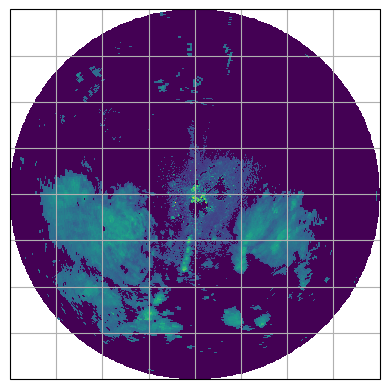

In [9]:
map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=cf1["sweep_1"].latitude.values,
    central_longitude=cf1["sweep_1"].longitude.values,
)
pm = cf1["sweep_1"].DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

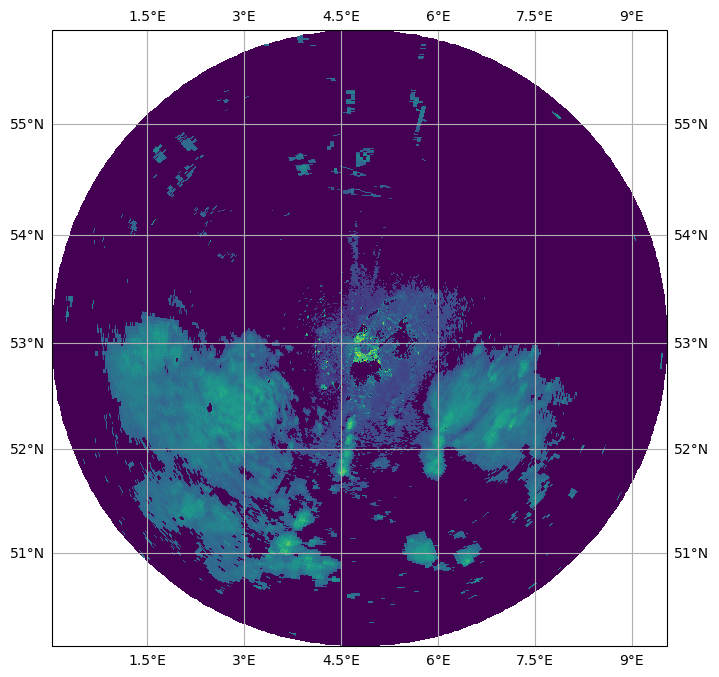

In [10]:
map_proj = ccrs.Mercator(central_longitude=cf1["sweep_1"].longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
pm = cf1["sweep_1"].DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

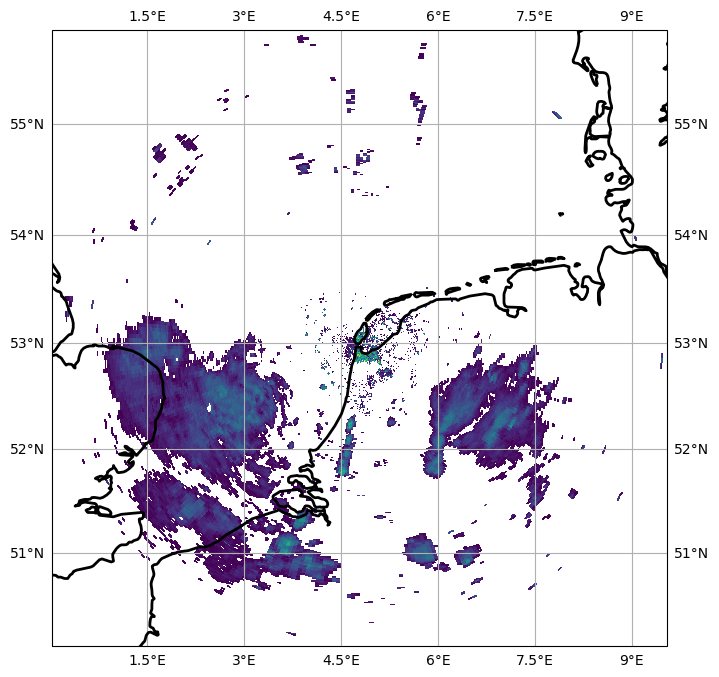

In [11]:
import cartopy.feature as cfeature


def plot_borders(ax):
    borders = cfeature.NaturalEarthFeature(
        category="physical", name="coastline", scale="10m", facecolor="none"
    )
    ax.add_feature(borders, edgecolor="black", lw=2, zorder=4)


map_proj = ccrs.Mercator(central_longitude=cf1["sweep_1"].longitude.values)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)

DBZH = cf1["sweep_1"].DBZH
pm = DBZH.where(DBZH > 0).wradlib.plot_ppi(ax=ax)
plot_borders(ax)
ax.gridlines(draw_labels=True)

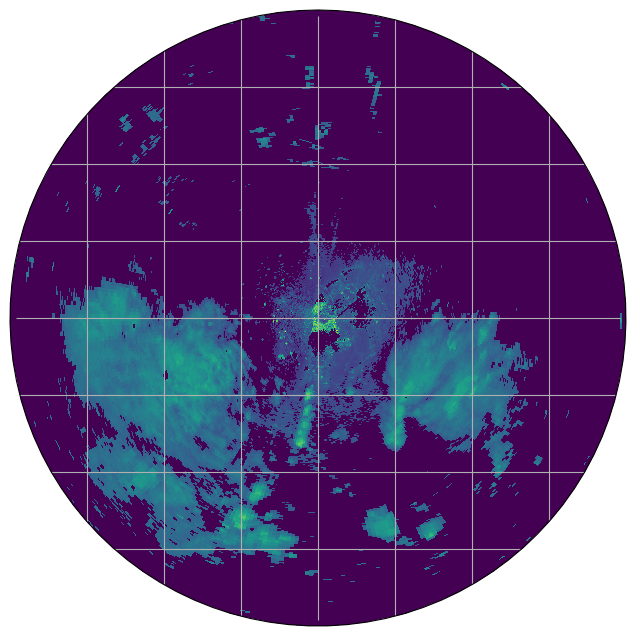

In [12]:
import matplotlib.path as mpath

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

map_proj = ccrs.AzimuthalEquidistant(
    central_latitude=cf1["sweep_1"].latitude.values,
    central_longitude=cf1["sweep_1"].longitude.values,
)
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection=map_proj)
ax.set_boundary(circle, transform=ax.transAxes)

pm = cf1["sweep_1"].DBZH.wradlib.plot_ppi(proj=map_proj, ax=ax)
ax = pl.gca()
ax.gridlines(crs=map_proj)

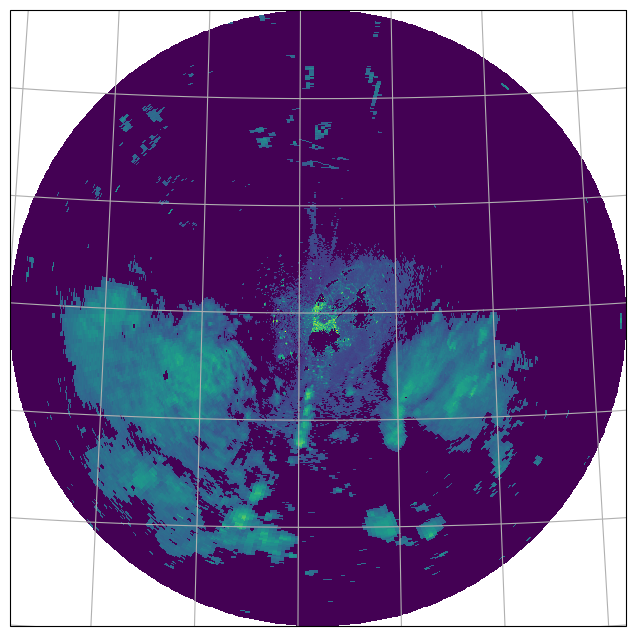

In [13]:
fig = pl.figure(figsize=(10, 8))
proj = ccrs.AzimuthalEquidistant(
    central_latitude=cf1["sweep_1"].latitude.values,
    central_longitude=cf1["sweep_1"].longitude.values,
)
ax = fig.add_subplot(111, projection=proj)
pm = cf1["sweep_1"].DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

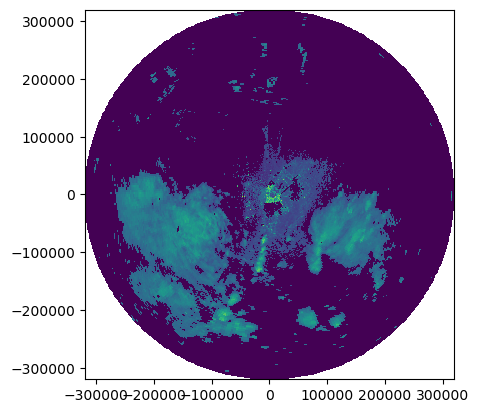

In [14]:
dbz = cf1["sweep_1"]
dbz.DBZH.wradlib.plot_ppi()

### Inspect radar moments

The dataarrays can be accessed by key or by attribute. Each dataarray has the datasets dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [15]:
cf1["sweep_1"].DBZH

<xarray.DataArray 'DBZH' (time: 360, range: 320)>
[115200 values with dtype=float32]
Coordinates: (12/14)
    sweep_mode  <U20 ...
    latitude    float32 ...
    altitude    float32 ...
    longitude   float32 ...
    elevation   (time) float32 ...
    azimuth     (time) float32 ...
    ...          ...
    z           (time, range) float32 ...
    gr          (time, range) float32 ...
    rays        (time, range) float32 ...
    bins        (time, range) float32 ...
    x           (time, range) float32 ...
  * time        (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 2011-...
Attributes:
    IMAGE_VERSION:  1.2
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H
    units:          dBZ

In [16]:
cf1["sweep_1"]

<xarray.Dataset>
Dimensions:       (time: 360, range: 320)
Coordinates: (12/14)
    sweep_mode    <U20 ...
    latitude      float32 ...
    altitude      float32 ...
    longitude     float32 ...
    elevation     (time) float32 ...
    azimuth       (time) float32 ...
    ...            ...
    z             (time, range) float32 ...
    gr            (time, range) float32 ...
    rays          (time, range) float32 ...
    bins          (time, range) float32 ...
    x             (time, range) float32 ...
  * time          (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 201...
Data variables:
    DBZH          (time, range) float32 ...
    sweep_number  int64 ...
    follow_mode   <U4 ...
    prt_mode      <U5 ...
    fixed_angle   float32 ...

### Create simple plot

Using xarray features a simple plot can be created like this. Note the `sortby('time')` method, which sorts the radials by time.

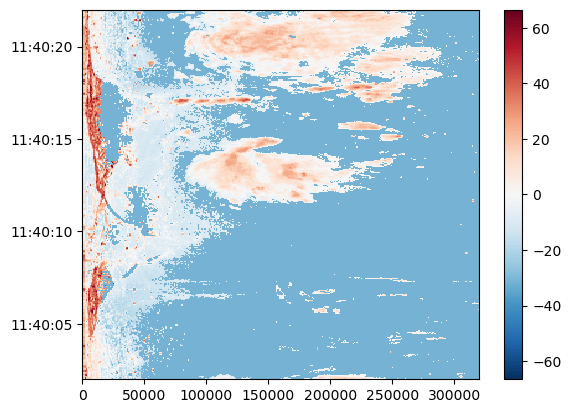

In [17]:
cf1["sweep_1"].DBZH.copy().sortby("time").plot(add_labels=False)

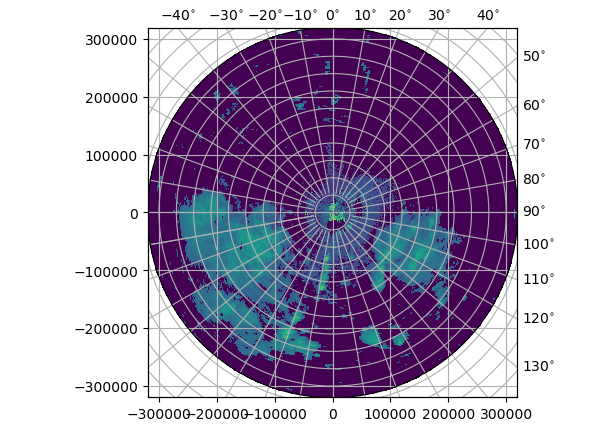

In [18]:
pm = cf1["sweep_1"].DBZH.wradlib.plot_ppi(proj={"latmin": 33e3})

In [19]:
h5_tempfile = tempfile.NamedTemporaryFile(suffix=".h5").name
nc_tempfile = tempfile.NamedTemporaryFile(suffix=".nc").name
cf1.to_odim(h5_tempfile)
cf1.to_cfradial2(nc_tempfile)

### Import again

In [20]:
cf1a = OdimH5(h5_tempfile, standard="cf", georef=True)
cf1b = CfRadial(nc_tempfile, georef=True)

In [21]:
cf1a["sweep_1"]

<xarray.Dataset>
Dimensions:       (time: 360, range: 320)
Coordinates: (12/14)
    sweep_mode    <U20 ...
    latitude      float32 ...
    altitude      float32 ...
    longitude     float32 ...
    elevation     (time) float32 ...
    azimuth       (time) float32 ...
    ...            ...
    z             (time, range) float32 ...
    gr            (time, range) float32 ...
    rays          (time, range) float32 ...
    bins          (time, range) float32 ...
    x             (time, range) float32 ...
  * time          (time) datetime64[ns] 2011-06-10T11:40:06.694446592 ... 201...
Data variables:
    DBZH          (time, range) float32 ...
    sweep_number  int64 ...
    follow_mode   <U4 ...
    prt_mode      <U5 ...
    fixed_angle   float32 ...

### Check equality

In [22]:
xr.testing.assert_equal(cf1.root, cf1a.root)
xr.testing.assert_equal(cf1["sweep_1"], cf1a["sweep_1"].sortby("azimuth"))
xr.testing.assert_equal(cf1.root, cf1b.root)
xr.testing.assert_allclose(cf1["sweep_1"], cf1b["sweep_1"].sortby("azimuth"))

### Mask some values

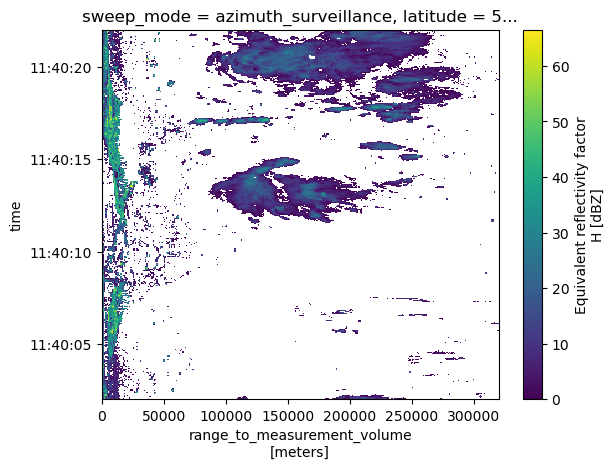

In [23]:
cf1["sweep_1"]["DBZH"] = cf1["sweep_1"]["DBZH"].where(cf1["sweep_1"]["DBZH"] >= 0)
cf1["sweep_1"]["DBZH"].sortby("time").plot()

## Load Cf/Radial1 Volume Data

In [24]:
fpath = "netcdf/cfrad.20080604_002217_000_SPOL_v36_SUR.nc"
f = wrl.util.get_wradlib_data_file(fpath)
cf2 = CfRadial(f)  # , georef=True)

### Fix duplicate rays

In [25]:
for i, key in enumerate(cf2):
    num_rays = int(360 // cf2[key].azimuth.diff("time").median())
    start_rays = cf2[key].dims["time"] - num_rays
    cf2[key] = (
        cf2[key].sortby("time").isel(time=slice(start_rays, start_rays + num_rays))
    )

### Inspect root group

In [26]:
cf2.root

<xarray.Dataset>
Dimensions:              (sweep: 9)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int32 ...
    platform_type        |S32 ...
    primary_axis         |S32 ...
    status_xml           |S1 ...
    instrument_type      |S32 ...
    time_coverage_start  |S32 ...
    time_coverage_end    |S32 ...
    latitude             float64 ...
    longitude            float64 ...
    altitude             float64 ...
    sweep_fixed_angle    (sweep) float32 ...
    sweep_group_name     (sweep) <U7 'sweep_1' 'sweep_2' ... 'sweep_8' 'sweep_9'
Attributes: (12/14)
    Conventions:         CF/Radial instrument_parameters radar_parameters rad...
    version:             1.2
    title:               TIMREX
    institution:         
    references:          
    source:              
    ...                  ...
    instrument_name:     SPOLRVP8
    site_name:           
    scan_name:           
    scan_id:             0
    platform_is_mobile:  false
    n_gates_vary:        false

### Inspect sweep group(s)

In [27]:
cf2["sweep_1"]

<xarray.Dataset>
Dimensions:             (time: 480, range: 996)
Coordinates:
    sweep_mode          <U20 'azimuth_surveillance'
  * time                (time) datetime64[ns] 2008-06-04T00:15:03 ... 2008-06...
  * range               (range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
    azimuth             (time) float32 ...
    elevation           (time) float32 ...
    longitude           float64 ...
    latitude            float64 ...
    altitude            float64 ...
Data variables: (12/16)
    sweep_number        int32 ...
    polarization_mode   |S32 ...
    prt_mode            |S32 ...
    follow_mode         |S32 ...
    fixed_angle         float32 ...
    target_scan_rate    float32 ...
    ...                  ...
    antenna_transition  (time) int8 ...
    n_samples           (time) int32 ...
    r_calib_index       (time) int8 ...
    scan_rate           (time) float32 ...
    DBZ                 (time, range) float32 ...
    VR                  (time, range) float32 ...

### Inspect radar moments

In [28]:
cf2["sweep_1"].DBZ

<xarray.DataArray 'DBZ' (time: 480, range: 996)>
[478080 values with dtype=float32]
Coordinates:
    sweep_mode  <U20 'azimuth_surveillance'
  * time        (time) datetime64[ns] 2008-06-04T00:15:03 ... 2008-06-04T00:1...
  * range       (range) float32 150.0 300.0 450.0 ... 1.492e+05 1.494e+05
    azimuth     (time) float32 ...
    elevation   (time) float32 ...
    longitude   float64 ...
    latitude    float64 ...
    altitude    float64 ...
Attributes:
    long_name:             Computed Horizontal Co-polar Reflectivit
    standard_name:         equivalent_reflectivity_factor
    units:                 dBZ
    threshold_field_name:  
    threshold_value:       -9999.0
    sampling_ratio:        1.0
    grid_mapping:          grid_mapping

### Create simple plot

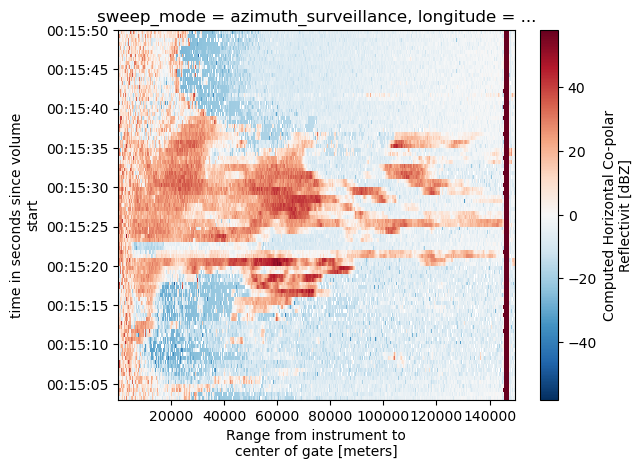

In [29]:
cf2["sweep_1"].DBZ.plot()

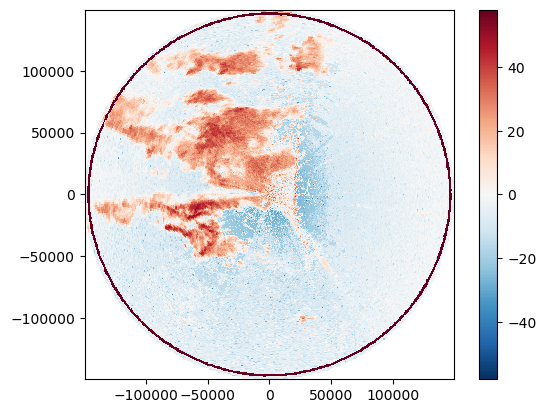

In [30]:
cf2["sweep_1"].DBZ.pipe(wrl.georef.georeference_dataset).plot.pcolormesh(
    x="x", y="y", add_labels=False
)
pl.gca().set_aspect("equal")

### Use wradlib DataArray connector

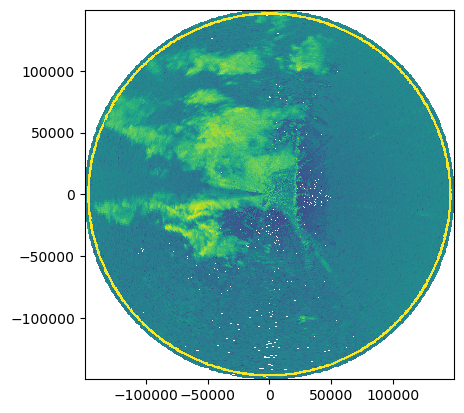

In [31]:
pm = cf2["sweep_1"].DBZ.pipe(wrl.georef.georeference_dataset).wradlib.plot_ppi()

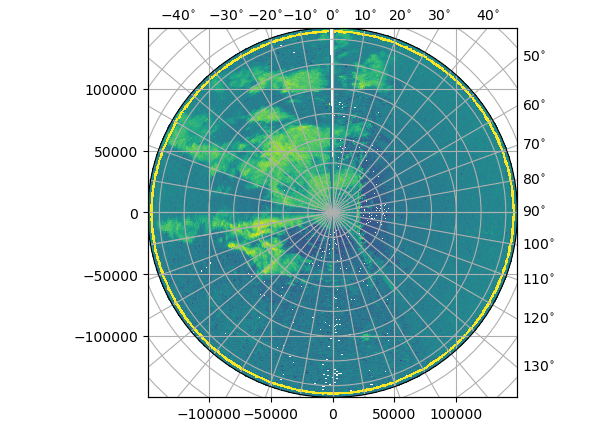

In [32]:
pm = (
    cf2["sweep_1"].DBZ.pipe(wrl.georef.georeference_dataset).wradlib.plot_ppi(proj="cg")
)

### Export data to Cf/Radial2 and ODIM_H5

In [33]:
h5_tempfile = tempfile.NamedTemporaryFile(suffix=".h5").name
nc_tempfile = tempfile.NamedTemporaryFile(suffix=".nc").name
cf2.to_cfradial2(nc_tempfile)
cf2.to_odim(h5_tempfile)

In [34]:
cf2["sweep_1"]

<xarray.Dataset>
Dimensions:             (time: 480, range: 996)
Coordinates:
    sweep_mode          <U20 'azimuth_surveillance'
  * time                (time) datetime64[ns] 2008-06-04T00:15:03 ... 2008-06...
  * range               (range) float32 150.0 300.0 ... 1.492e+05 1.494e+05
    azimuth             (time) float32 123.0 123.8 124.5 ... 120.8 121.5 122.2
    elevation           (time) float32 0.1648 0.1648 0.2142 ... 0.5109 0.5109
    longitude           float64 120.4
    latitude            float64 22.53
    altitude            float64 45.0
Data variables: (12/16)
    sweep_number        int32 0
    polarization_mode   |S32 b'not_set'
    prt_mode            |S32 b'not_set'
    follow_mode         |S32 b'not_set'
    fixed_angle         float32 0.4999
    target_scan_rate    float32 -9.999e+03
    ...                  ...
    antenna_transition  (time) int8 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    n_samples           (time) int32 192 192 192 192 192 ... 192 192 192 192 192
    r_calib_index       (time) int8 -1 -1 -1 -1 -1 -1 -1 ... -1 -1 -1 -1 -1 -1
    scan_rate           (time) float32 -3.277e+04 -3.277e+04 ... -3.277e+04
    DBZ                 (time, range) float32 -6.079 10.45 ... -2.259 0.4694
    VR                  (time, range) float32 26.71 24.83 ... -20.84 17.25

### Import again

In [35]:
cf2a = CfRadial(nc_tempfile)
cf2b = OdimH5(h5_tempfile, standard="cf")

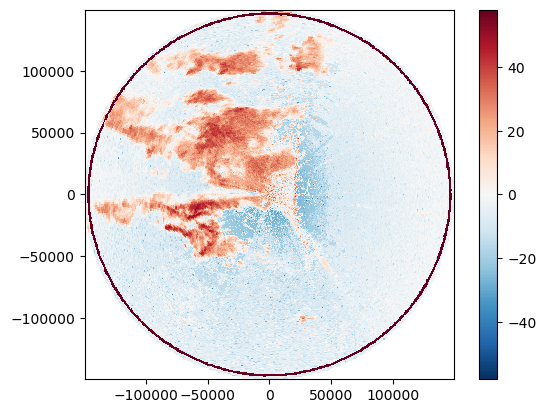

In [36]:
cf2a["sweep_1"].DBZ.pipe(wrl.georef.georeference_dataset).plot.pcolormesh(
    x="x", y="y", add_labels=False
)
pl.gca().set_aspect("equal")

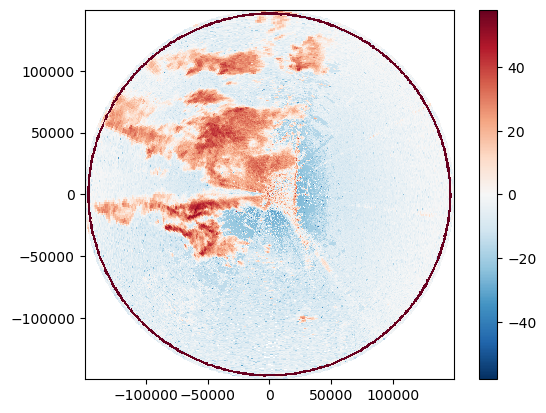

In [37]:
cf2b["sweep_1"].DBZ.pipe(wrl.georef.georeference_dataset).plot.pcolormesh(
    x="x", y="y", add_labels=False
)
pl.gca().set_aspect("equal")

### Check equality

For Cf/Radial there are issues with nan, which need to be fixed. For the ODIM_H5 intercomparison there are too problems with nan and issues with attributes.

In [38]:
xr.testing.assert_equal(cf2.root, cf2a.root)
xr.testing.assert_allclose(cf2["sweep_1"], cf2a["sweep_1"])
xr.testing.assert_allclose(
    cf2.root.drop_vars(["volume_number", "status_xml"]),
    cf2b.root.drop_vars(["volume_number", "status_xml", "altitude_agl", "frequency"]),
)
drop = set(cf2["sweep_1"]) ^ set(cf2b["sweep_1"]) | set(
    ["prt_mode", "follow_mode", "time"]
)
xr.testing.assert_allclose(
    cf2["sweep_1"].drop_vars(drop).sortby("azimuth"),
    cf2b["sweep_1"].drop_vars(drop, errors="ignore").sortby("azimuth"),
)